<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/Final_Project_Phone_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libraries


In [0]:
#@title Install non-generic libraries
#@markdown vaderSentiment, pyLDAvis
!pip install vaderSentiment
!pip install pyLDAvis

In [0]:
#@title Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import re
import string
import pickle
import time
import sys
#!{sys.executable} -m spacy download en
import math
from pprint import pprint
import warnings


# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('movie_reviews')

#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

# SpaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

# Sentiment Analysis
import textblob as tb
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plots
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import pyLDAvis.gensim
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# Google Colab imports
from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Data

In [0]:
#@title File Upload
#@markdown Fetch all the required files.

#@markdown **reviews.csv**: all available reviews\
#@markdown **items.csv**: all phones available

# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('drive')

reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Exploratory Data Analysis

## Items Dataset
We have **720 phone models** and **10 features**.  
*rating*, *totalReviews*, *price* and *originalPrice* are **numerical**.  
All other features are **strings**.   

No significant NA's in this dataset.  

**Samsung** has the highest # of phones with 346, followed by **Motorola** having 105 and **Apple** has 63 phones.  

**Xiaomi** has the best rating of 4.4/5 followed by **HUAWEI** and then **ASUS**.

In [0]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [0]:
items.shape

(720, 10)

In [0]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [0]:
item_brand = items.groupby('brand').agg({'asin':['count'], 'rating':['mean'], 'totalReviews':['sum']})
item_brand.columns = ['count_phone', 'avg_rating', 'total_reviews']
item_brand.sort_values(by="count_phone", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Samsung,346,3.632659,37701
Motorola,105,3.643810,9419
Apple,63,3.782540,6315
Xiaomi,46,4.415217,5574
Nokia,44,3.386364,6182
Google,38,3.771053,4238
HUAWEI,32,4.021875,2467
Sony,27,3.788889,3312
OnePlus,10,3.580000,406


In [0]:
item_brand.sort_values(by="avg_rating", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Xiaomi,46,4.415217,5574
HUAWEI,32,4.021875,2467
ASUS,5,3.860000,263
Sony,27,3.788889,3312
Apple,63,3.782540,6315
Google,38,3.771053,4238
Motorola,105,3.643810,9419
Samsung,346,3.632659,37701
OnePlus,10,3.580000,406


## Reviews Dataset
We have **67986 reviews** with **8 features**.  
*rating* and *helpfulVotes* are **numerical**.  
All other features are **strings**.

*helpfulVotes* has a lot of NA's.  
The other features have very few NA's.  

40% of the reviews are for **Samsung**.

In [0]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [0]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [0]:
reviews.shape

(67986, 8)

In [0]:
#reviews.head(2)
#reviews.loc[1,'body']
#tb.TextBlob(reviews.loc[1,'title'])
#tb.TextBlob("Text Messaging Doesn't Work", analyzer=NaiveBayesAnalyzer()).sentiment

## Merged Dataset

The dataset pulled atleast 80% of data available at that time per brand. **Samsung**, **Motorola** and **Nokia** have 90+% data.  

The highest deviation in ratings due to missing reviews is for OnePlus phones at 0.63. **Samsung**, **Motorola**, **Nokia** and **Apple** have less than 0.2 rating deviation.  

We see a bi-modal distribution of ratings for all the brands which is also representative of the plot with all brands combined.  



In [0]:
# Create a merged dataframe
df = pd.merge(reviews, items, on='asin')

# Find brand-wise summary
df_brand = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
df_brand.columns = ['brand', 'reviews', 'avg_avlb_rating']
df_brand = df_brand.sort_values(by='reviews',ascending=False)
brand_summary = pd.merge(df_brand, item_brand, on='brand')
brand_summary['data_ratio'] = brand_summary['reviews']/brand_summary['total_reviews']
brand_summary['rating_dev'] = brand_summary['avg_avlb_rating'] - brand_summary['avg_rating']
brand_summary.to_csv("brand_summary.csv")
brand_rating = pd.pivot_table(df, values='asin', index=['brand'], columns=['rating_x'], aggfunc='count')
brand_rating.to_csv("brand_rating.csv")
# Run this only when you want to overwrite
#!cp brand_rating.csv "drive/My Drive/Amazon_Reviews/"
#!cp brand_summary.csv "drive/My Drive/Amazon_Reviews/"
brand_summary

NameError: ignored

In [0]:
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,41,23,25,38,124
Apple,1191,243,322,545,2844
Google,883,286,267,435,1916
HUAWEI,246,63,124,268,1524
Motorola,1562,542,653,1310,4813
Nokia,1253,457,540,910,2755
OnePlus,46,6,13,45,237
Samsung,6646,1891,2292,4128,18672
Sony,511,259,280,496,1650


In [0]:
brand_rating = brand_rating.div(brand_rating.sum(axis=1), axis=0)
brand_rating.plot(kind='bar', figsize=(10,8)).set_facecolor("white");

NameError: ignored

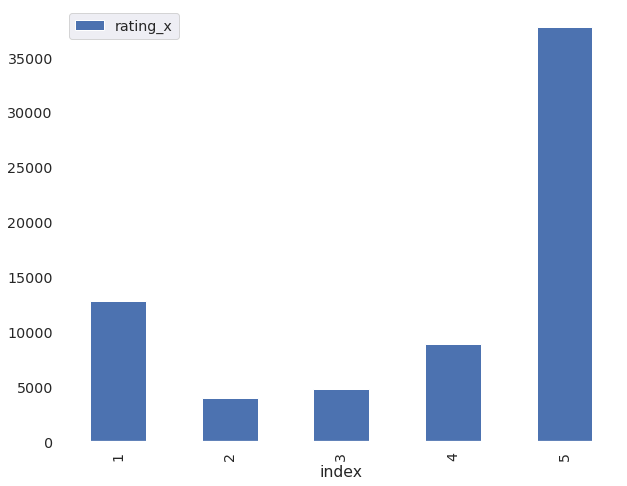

In [0]:
pd.DataFrame(df['rating_x'].value_counts()).reset_index().sort_values(by="index").plot(kind="bar", x="index", figsize=(10,8)).set_facecolor("white");

# Sentiment Analysis

In [0]:
#@title Review Data
#@markdown Select the following option if you want to read the file that was already generated to save time. \

pick_from_drive = True #@param {type:"boolean"}
if pick_from_drive:
  file_id = '1-FKpLOlBGNMn8aclDygJ460dIJt-N9Q-'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_reviews.csv')
  df_reviews = pd.read_csv("df_reviews.csv")
  print("File read from drive")
else:
  df_reviews = df[['body', 'brand']].reset_index()
  df_reviews['body'] = df_reviews['body'].fillna("")
  df_reviews['word_count'] = 0
  df_reviews['most_common'] = ""
  df_reviews['common_count'] = 0
  df_reviews['body_clean'] = ""
  stop_words = set(stopwords.words("english"))
  for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub(r'[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub(r'\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    # store cleaned words
    df_reviews.iloc[i,6] = ' '.join(filtered_rev)

    #Compute number of words
    df_reviews.iloc[i,3] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,5] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,4] = ""
        df_reviews.iloc[i,5] = 0
  df_reviews.head()
  #df_reviews.to_csv("df_reviews.csv")
  #!cp df_reviews.csv "drive/My Drive/Amazon_Reviews/"
#df_reviews['word_count'].mean()
### example usage ###
#tb.TextBlob("good is good", analyzer=NaiveBayesAnalyzer()).sentiment
#sent = "good bad"
#analyzer = SentimentIntensityAnalyzer()
#analyzer.polarity_scores(sent)['compound']

#df_sent.to_csv("df_sent_0.csv")
#!cp df_sent_0.csv "drive/My Drive/Amazon_Reviews/"

File read from drive


In [0]:
#@title Sentiment Data

pick_from_drive = True #@param {type:"boolean"}

if pick_from_drive:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_sent_hybrid.csv')
  df_sent = pd.read_csv("df_sent_hybrid.csv")
  print("File read from drive")
else:
  # Create basic template of df for Sentiment Analysis
  df_sent = df[['body', 'brand', 'rating_x']].reset_index()
  df_sent['sent_tb'] = 0
  df_sent['tb_p'] = 0
  df_sent['tb_n'] = 0
  df_sent['tbnb_p'] = 0
  df_sent['tbnb_n'] = 0
  df_sent['sent_vader'] = 0
  df_sent['vader_p'] = 0
  df_sent['vader_n'] = 0

File read from drive


In [0]:
#@title Simple TextBlob Analyzer
cutoff_sent =  0#@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    #Pick a review
    rev = str(df_sent.iloc[i,1])

    # TextBlob Sentiment Analyzer
    df_sent.iloc[i,4] = tb.TextBlob(rev).sentiment.polarity

    # Pessimistic approach, neutral sentiment => bad review
    if df_sent.iloc[i,4] > cutoff_sent:
      df_sent.iloc[i,5] = 1
    else:
      df_sent.iloc[i,6] = 1

Data picked from drive


In [0]:
#@title TextBlob Analyzer: NaiveBayesAnalyzer
cutoff_sent = 0 #@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    #Pick a review
    rev = str(df_sent.iloc[i,1])

    # TextBlob Sentiment Analyzer with Naive Bayes
    tb_sent_class = tb.TextBlob(rev, analyzer=NaiveBayesAnalyzer()).sentiment.classification

    # TextBlob with Naive Bayes Analyzer
    if tb_sent_class == "pos":
      df_sent.iloc[i,7] = 1
    else:
      df_sent.iloc[i,8] = 1

KeyboardInterrupt: ignored

In [0]:
#@title VADER Analyzer
cutoff_sent =  0#@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    # Pick a review
    rev = str(df_sent.iloc[i,1])
    rating = df_sent.iloc[i,3]

    # VADER Sentiment Analyzer
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(rev)
    score = vs['compound']
    df_sent.iloc[i,9] = score

    if score >= cutoff_sent:
      df_sent.iloc[i,10] = 1
    else:
      df_sent.iloc[i,11] = 1
  #df_sent.to_csv("df_sent_hybrid.csv")
  #!cp df_sent_hybrid.csv "drive/My Drive/Amazon_Reviews/"
  #pd.concat([df_reviews, df['rating_x']], axis=1)

Data picked from drive


In [0]:
#@title Brand-wise Sentiments
review_sentiment = df_sent.groupby('brand').agg({'sent_tb':['mean'], 
                                                 'tb_p':['sum'],
                                                 'tb_n':['sum'],
                                                 'sent_vader':['mean'],
                                                 'vader_p':['sum'],
                                                 'vader_n':['sum']}).reset_index()
review_sentiment.columns = ['brand', 'avg_sent_tb', 'tb_p', 'tb_n', 'avg_sent_vader', 'vader_p', 'vader_n']
review_sentiment

,brand,avg_sent_tb,tb_p,tb_n,avg_sent_vader,vader_p,vader_n
0,ASUS,0.253001,198,53,0.450343,204,47
1,Apple,0.238408,3377,1768,0.303738,4045,1100
2,Google,0.243897,2904,883,0.371158,2896,891
3,HUAWEI,0.301263,1624,601,0.456779,1921,304
4,Motorola,0.271063,6742,2138,0.405286,7232,1648
5,Nokia,0.237997,4333,1582,0.373347,4631,1284
6,OnePlus,0.294085,281,66,0.488430,296,51
7,Samsung,0.276568,24076,9553,0.361681,27019,6610
8,Sony,0.268844,2526,670,0.447593,2581,615
9,Xiaomi,0.280397,2921,1490,0.396646,3798,613


In [0]:
#@title Ratings Summary

text = "body" #@param {type:"string"} ['title', 'body']
cutoff = "hybrid" #@param {type:"string"} ['0', '0.5', 'hybrid']

def pivot_ratings(df):
  return pd.pivot_table(df, values='index', index=['vader_p'], columns=['rating_x'], aggfunc='count')

if text == "body":
  if cutoff == "0/5":
    filename = "df_sent_0pt5.csv"
  else:
    filename = "df_sent_"+cutoff+".csv"
else:
  if cutoff == "0.5":
    filename = "df_sent_title_0pt5.csv"
  else:
    if cutoff == "hybrid":
      filename = "df_sent_hybrid.csv"
      print("No data for hybrid title defaulting to df_sent_hybrid.csv")
    else:
      filename = "df_sent_title"+cutoff+".csv"
data = pd.read_csv("/content/drive/My Drive/Amazon_Reviews/"+filename)
pivot_ratings(data)

In [0]:
#@title Classification tables
sentiment = "negative" #@param {type:"string"} ['positive', 'negative']
rating = "4 or 5" #@param {type:"string"} ['1 or 2', '3', '4 or 5']
package = "VADER" #@param {type:"string"} ['VADER', 'TextBlob']
brand = "Samsung" #@param {type:"string"} ['Motorola', 'Nokia', 'Samsung', 'HUAWEI', 'Sony', 'Apple', 'Google', 'ASUS', 'OnePlus', 'Xiaomi']

temp_df = pd.DataFrame()
if package == "VADER":
  if sentiment == "positive":
    if rating == "1 or 2":
      temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] < 3)]
    elif rating == "3":
      temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] == 3)]
    else:
      temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] > 3)]
  else:
    if rating == "1 or 2":
      temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] < 3)]
    elif rating == "3":
      temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] == 3)]
    else:
      temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] > 3)]
else:
  if sentiment == "positive":
    if rating == "1 or 2":
      temp_df = df_sent[(df_sent['tb_p'] == 1) & (df_sent['rating_x'] < 3)]
    elif rating == "3":
      temp_df = df_sent[(df_sent['tb_p'] == 1) & (df_sent['rating_x'] == 3)]
    else:
      temp_df = df_sent[(df_sent['tb_p'] == 1) & (df_sent['rating_x'] > 3)]
  else:
    if rating == "1 or 2":
      temp_df = df_sent[(df_sent['tb_n'] == 1) & (df_sent['rating_x'] < 3)]
    elif rating == "3":
      temp_df = df_sent[(df_sent['tb_n'] == 1) & (df_sent['rating_x'] == 3)]
    else:
      temp_df = df_sent[(df_sent['tb_n'] == 1) & (df_sent['rating_x'] > 3)]
temp_df[temp_df['brand']==brand]

# Topic Modeling

In [0]:
#@title Import data for Topic Modeling
pick_from_drive = True #@param {type:"boolean"}

if pick_from_drive:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_sent_hybrid.csv')
  topic_df = pd.read_csv("df_sent_hybrid.csv")
  topic_df['brand'] = topic_df['brand'].astype(str)
  print("Data imported from Drive")
else:
  print("Using current session Data")

Data imported from Drive


In [0]:
#@title Select Brand & Sentiment
brand = "Xiaomi" #@param {type:"string"} ['Motorola', 'Nokia', 'Samsung', 'HUAWEI', 'Sony', 'Apple', 'Google', 'ASUS', 'OnePlus', 'Xiaomi']
sentiment_topic = "positive" #@param {type:"string"} ['negative', 'positive']

# Subset brand data
topic_df_brand = topic_df[topic_df['brand']==brand]
topic_df_brand = topic_df_brand.astype({'body': 'str'})

# Filter Positive Reviews
if sentiment_topic == "positive":
  vader_sentiment = topic_df_brand['sent_vader']
  rating = topic_df_brand['rating_x']
  # Pick the REALLY good sentiment in bad rated review
  brand_neg = topic_df_brand[((topic_df_brand['vader_p']==1) & (topic_df_brand['rating_x']!=1)) |
                             ((topic_df_brand['sent_vader']>=0.75) & (topic_df_brand['rating_x']==1))]

# Filter Negative Review
else:
  brand_neg = topic_df_brand[(((topic_df_brand['vader_n']==1) & (topic_df_brand['rating_x']!=5)) |
                             ((topic_df_brand['sent_vader']<=-0.75) & (topic_df_brand['rating_x']==5)))]

In [0]:
#@title Clean data module
keywords = topic_df["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
lemma = WordNetLemmatizer()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)

#dtm = cv.fit_transform(topic_df["body"])
#common_words_bigrams = get_top_n_bigram(topic_df_Apple_neg['body'])
#bigrams_list = [a_tuple[0] for a_tuple in common_words_bigrams]

In [0]:
#@title Gensim
import numpy
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Stop Words
custom_stop_words = stopwords.words('english')
custom_stop_words.extend(['phone','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Common keyowords
keywords = topic_df["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
keywords.append("ipad")

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub(r"\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

def process_words(texts, stop_words=custom_stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]   
    # Remove other keywords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in keywords] for doc in texts_out]
    return texts_out

# Convert to list
data = brand_neg.body.values.tolist()
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_ready = process_words(data_words)

num_topics =  8#@param {type:"integer"}

# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency using BOW model
corpus = [id2word.doc2bow(text) for text in data_ready]

#Using Tfidf - replace corpus with corpus_tfidf
from gensim import corpora, models
#tfidf = models.TfidfModel(corpus)
#corpus_tfidf = tfidf[corpus]

#corpus = [id2word.doc2bow(text) for text in data_ready]
# Build LDA model
#Nmf(corpus_tfidf, num_topics=50, kappa=0.1, eval_every=5) #NMF
lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=10,
                passes=10,
                alpha='symmetric',
                iterations=100,
                per_word_topics=True)

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    # print(row)
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      if j == 0:  # => dominant topic
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
      else:
        break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
  sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                          grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                          axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9028,"camera, great, work, battery, well, fast, day, buy, price, charger","[ridiculously, fast, charge, great, battery, life, fast, processor]"
1,1.0,0.8248,"price, feel, expect, happy, bit, year, purchase, old, long, instead","[excelent, purshase, working, suppose]"
2,2.0,0.8542,"look, feature, product, money, value, telefono, load, early, original, ago","[auto, voice, call, recording, facility]"
3,3.0,0.7810,"thing, excellent, return, note, video, network, suck, awesome, enough, give","[smartphone, meet, requirement]"
4,4.0,0.7083,"love, pic, bad, little, perfect, indoor, responsive, first, band, task","[love, bad]"
5,5.0,0.7812,"much, quality, screen, display, amazing, photo, picture, sound, hand, clear","[understand, anytime, best]"
6,6.0,0.7812,"really, screen, better, overall, set, sure, back, compete, worth, resolution","[producto, cumple, con]"
7,7.0,0.8541,"beautiful, arrive, star, cost, decent, redmi_note_pro, mean, ever, soon, spec","[puse, llevo, vario, mese, satisfecho]"


In [0]:
#@title Word Cloud of Top Words
max_words = 10 #@param {type:"integer"}
# Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=custom_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=max_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=num_topics,num_words=max_words,formatted=False)
columns= math.ceil(num_topics/2)
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(3*columns,3*rows), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  if i < num_topics:
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

NameError: ignored

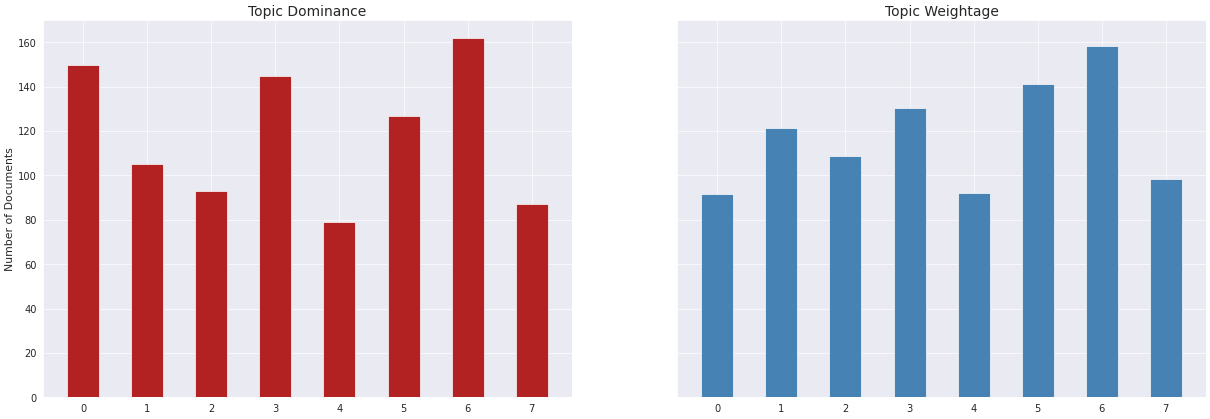

In [0]:
#@title Dominant Topics and Weightage
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), dpi=50, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Topic Dominance', fontdict=dict(size=20))
ax1.set_ylabel('Number of Documents')
#ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
#ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Topic Weightage', fontdict=dict(size=20))

plt.show()

In [0]:
#@title Visualize with pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.257126  0.124749       1        1  17.437113
5      0.305488  0.149010       2        1  16.683523
1      0.032955 -0.342876       3        1  15.352009
3     -0.074122  0.012329       4        1  13.751329
2      0.030493  0.016614       5        1  12.188826
7      0.021887 -0.016796       6        1   9.364505
4     -0.021777  0.048877       7        1   8.362230
0     -0.037798  0.008092       8        1   6.860465, topic_info=          Term        Freq       Total Category  logprob  loglift
198        bad  191.000000  191.000000  Default  30.0000  30.0000
113     screen  251.000000  251.000000  Default  29.0000  29.0000
51     battery  202.000000  202.000000  Default  28.0000  28.0000
120       work  226.000000  226.000000  Default  27.0000  27.0000
97         day  119.000000  119.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1869  earphone   11.825729   13.739223   Topic8  -4.3218   2.5294
655    network    3.923486    4.646685   Topic8  -5.4251   2.5102
795    visible    3.799223    4.522557   Topic8  -5.4573   2.5051
1826     rough   10.032689   12.693518   Topic8  -4.4862   2.4442
1874  refunded    6.815546    9.365913   Topic8  -4.8729   2.3615

[295 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
92        1  0.963189       able
1199      7  0.972000  accessory
525       6  0.897721    account
1317      8  0.958700    adapter
1079      8  0.950765  advertise
...     ...       ...        ...
150       5  0.971184       well
599       2  0.987666       wifi
120       1  0.995333       work
1576      5  0.966852      worry
49        3  0.948161      wrong

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 2, 4, 3, 8, 5, 1])


Coherence Score:  0.37280413286395553


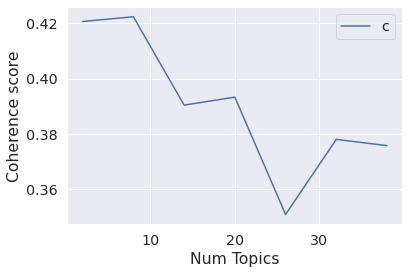

In [0]:
#@title Coherence Scores
from gensim.models.ldamodel import LdaModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## NMF

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

num_topics=6

corpus_nmf = [' '.join(text) for text in data_ready]
vectorizer = CountVectorizer(analyzer='word', max_features=5000,ngram_range=(2,3));

x_counts = vectorizer.fit_transform(corpus_nmf);
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

model = NMF(n_components=num_topics, init='nndsvd');
nmf_model=model.fit(xtfidf_norm)

def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);
get_nmf_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,great price,value money,excellent product,best ever,amazing price,work great
1,price buy,great value,product perfect,ever buy,absolutely amazing,amazing work
2,great great price,great value money,incomparable service,life day,really amazing,buy wife
3,great great,fast shipping,product describe,lightne fast,price well,battery life
4,snappy responsive,awesome value,product great,call call,great fast,great problem
5,price work,half price,half price,great far,fast amazing,like work
6,great camera,spend much,great camara,work perfectly,love amazing,work perfectly
7,fast shipping,last year,product love,love device,arrive today,great day
8,really amazing,processing power,love far,battery life,fall love,charger version
9,picture quality,impress far,overall excellent,great camera,still better,love work


# Predictions - Logistic Regression, Naive Bayes, SVM and Random Forests

In [0]:
#@title Data setup
topic_df['body'] = topic_df['body'].astype(str)
predictions_data = topic_df.copy()
predictions_data['clean_text'] = predictions_data['body'].apply(clean_text)
X = predictions_data.clean_text
y = predictions_data.rating_x
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

def round_perc(decimal):
  value = str(round(decimal*100, 2))+"%"
  return value
#tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,2))
#vectors = tfidf_vectorizer.fit_transform(topic_df['rating_x'])

In [0]:
#@title Logistic Regression
 
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=100,n_jobs=-1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy = %s' % round_perc(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))

Accuracy = 68.68%
              precision    recall  f1-score   support

           1       0.68      0.71      0.69      3844
           2       0.24      0.24      0.24      1122
           3       0.27      0.20      0.23      1409
           4       0.34      0.20      0.25      2606
           5       0.80      0.90      0.85     11415

    accuracy                           0.69     20396
   macro avg       0.47      0.45      0.45     20396
weighted avg       0.65      0.69      0.67     20396



In [0]:
#@title Support Vector Machines

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('Accuracy = %s' % round_perc(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))


Accuracy = 66.19%
              precision    recall  f1-score   support

           1       0.70      0.56      0.62      3844
           2       1.00      0.00      0.00      1122
           3       0.42      0.00      0.01      1409
           4       0.22      0.00      0.00      2606
           5       0.66      0.99      0.79     11415

    accuracy                           0.66     20396
   macro avg       0.60      0.31      0.29     20396
weighted avg       0.61      0.66      0.56     20396



In [0]:
#@title Naive Bayes Classifier

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('Accuracy = %s' % round_perc(accuracy_score(y_pred, y_test)))
print(classification_report(y_test, y_pred))

Accuracy = 64.9%
              precision    recall  f1-score   support

           1       0.77      0.49      0.60      3844
           2       0.00      0.00      0.00      1122
           3       0.00      0.00      0.00      1409
           4       0.33      0.00      0.00      2606
           5       0.63      1.00      0.77     11415

    accuracy                           0.65     20396
   macro avg       0.35      0.30      0.27     20396
weighted avg       0.54      0.65      0.55     20396



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#@title Random Forest
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', RandomForestClassifier())])

pipeline.fit(X_train, y_train)
pipeline_predictedRF= pipeline.predict(X_test)
print(metrics.classification_report(y_test, pipeline_predictedRF))
print('Accuracy = %s' % round_perc(accuracy_score(pipeline_predictedRF, y_test)))

              precision    recall  f1-score   support

           1       0.62      0.33      0.43      3844
           2       0.87      0.07      0.13      1122
           3       0.92      0.07      0.13      1409
           4       0.76      0.06      0.11      2606
           5       0.62      0.97      0.76     11415

    accuracy                           0.62     20396
   macro avg       0.76      0.30      0.31     20396
weighted avg       0.67      0.62      0.53     20396

Accuracy = 62.28%
